In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class Quantizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return (X * 10).astype(int)

In [3]:
%load_ext google.cloud.bigquery

In [4]:
%%bigquery df_indicadores_por_operadora

SELECT 

    tb1.IdOperadora, tb1.dtCompetenciaContapaga, COUNT(DISTINCT idBeneficiario) AS qtd_vidas,
    
    -- Indicadores ambulatoriais.
    SUM(IF(AMB_dsClassPassagem = "Consulta Eletiva", 1, 0)) / COUNT(DISTINCT idBeneficiario)                                 AS consultas_eletivas_por_beneficiario,
    SUM(IF(AMB_dsClassPassagem = "Pronto-Socorro", 1, 0)) / COUNT(DISTINCT idBeneficiario)                                   AS consultas_ps_por_beneficiario,
    SUM(IF(AMB_dsClassPassagem = "Exames" AND AMBINT_dsCategoriaExame = "Simples", 1, 0)) / COUNT(DISTINCT idBeneficiario)   AS exames_simples_por_beneficiario,
    SUM(IF(AMB_dsClassPassagem = "Exames" AND AMBINT_dsCategoriaExame = "Especiais", 1, 0)) / COUNT(DISTINCT idBeneficiario) AS exames_especiais_por_beneficiario,
    SUM(IF(AMBINT_dsTipoTerapia = "Psicologia", 1, 0)) / COUNT(DISTINCT idBeneficiario)                                      AS psicoterapias_por_beneficiario,
    
    -- TODO: exames_por_consulta_ps
    -- TODO: exames_por_consulta_eletiva
    -- TODO: perc_consultas_de_urgencia
    -- TODO: perc_conversao_ps_internacao
        
    -- Indicadores de internação.
    SAFE_DIVIDE(SUM(INT_vrPagoProcedimentoContaPaga_Internacao), COUNT(DISTINCT INT_IdPassagem_Internacao))                  AS preco_medio_internacao,
    SAFE_DIVIDE(COUNT(DISTINCT INT_IdPassagem_Internacao), COUNT(DISTINCT idBeneficiario))                                   AS taxa_internacao,
    SAFE_DIVIDE(SUM(IF(INT_FlagNeoNatal = "Sim", 1, 0)), SUM(IF(INT_FlagParto = "Sim", 1, 0)))                               AS perc_uti_neonatal_x_partos,
    SAFE_DIVIDE(SUM(IF(INT_FlagINTernacaoUTI = "Sim", 1, 0)), COUNT(DISTINCT INT_IdPassagem_Internacao))                     AS perc_interncoes_uti,
        
    -- TODO: permanencia_media_internacao
    -- TODO: perc_internacoes_curtas
    -- TODO: perc_reinternacoes
        
    -- Indicadores financeiros.
    SUM(vrPagoProcedimentoContaPaga) / COUNT(DISTINCT idBeneficiario)                                                        AS sinistro_per_capita,
    SAFE_DIVIDE(SUM(vrCoParticipacaoProcedimentoContaPaga), SUM(vrPagoProcedimentoContaPaga))                                AS perc_copart_sinistro,
    
    -- TODO: sinistro_por_grupo_despesa
    -- TODO: premio_per_capita
    
    1                                                                                                                        AS flag_indicador_operadora

FROM
    cosmic-shift-235317.fenix_bi.view_fato_sinistro AS tb1

INNER JOIN (
    SELECT 
        IdOperadora, MAX(dtCompetenciaContapaga) AS dtCompetenciaContapaga
    FROM
        cosmic-shift-235317.fenix_bi.view_fato_sinistro
    GROUP BY IdOperadora
) AS tb2 
    ON tb1.IdOperadora = tb2.IdOperadora AND tb1.dtCompetenciaContapaga = tb2.dtCompetenciaContapaga

GROUP BY tb1.IdOperadora, tb1.dtCompetenciaContapaga
ORDER BY tb1.IdOperadora, tb1.dtCompetenciaContapaga

Downloading: 100%|██████████| 19/19 [00:03<00:00,  5.42rows/s]


In [5]:
df_indicadores_por_operadora.head()

IdOperadora dtCompetenciaContapaga  qtd_vidas  \
0            1             2021-06-01       1823   
1            2             2021-02-01      16120   
2            5             2021-05-01       9551   
3            6             2021-02-01        737   
4            8             2021-05-01        149   

   consultas_eletivas_por_beneficiario  consultas_ps_por_beneficiario  \
0                             1.179923                       0.396599   
1                             0.072270                       0.019169   
2                             1.188567                       0.438069   
3                             0.392130                       1.111262   
4                             1.040268                       1.040268   

   exames_simples_por_beneficiario  exames_especiais_por_beneficiario  \
0                         4.848601                           0.643993   
1                         0.270409                           0.046216   
2                         4.025233                           0.494608   
3                         3.352782                           0.255088   
4                         3.610738                           0.369128   

   psicoterapias_por_beneficiario preco_medio_internacao  taxa_internacao  \
0                        0.437740         6708.537310924         0.065277   
1                        0.005149        11861.502781065         0.020968   
2                        0.503926         9385.423005671         0.055387   
3                        0.169607         5904.013125000         0.021710   
4                        0.026846        18179.130000000         0.013423   

   perc_uti_neonatal_x_partos  perc_interncoes_uti sinistro_per_capita  \
0                    0.000000             0.000000      1082.287372463   
1                    2.741935             3.568047       589.380937965   
2                    0.312621             4.034026      1224.128316407   
3                         NaN             0.000000       613.531411126   
4                         NaN             0.000000       542.746845638   

  perc_copart_sinistro  flag_indicador_operadora  
0                 0E-9                         1  
1                 0E-9                         1  
2          0.027190816                         1  
3                 0E-9                         1  
4          0.137562620                         1

In [6]:
X = df_indicadores_por_operadora \
    .drop(columns=['IdOperadora', 'dtCompetenciaContapaga', 'flag_indicador_operadora']) \
    .fillna(0)

X.head()

qtd_vidas  consultas_eletivas_por_beneficiario  \
0       1823                             1.179923   
1      16120                             0.072270   
2       9551                             1.188567   
3        737                             0.392130   
4        149                             1.040268   

   consultas_ps_por_beneficiario  exames_simples_por_beneficiario  \
0                       0.396599                         4.848601   
1                       0.019169                         0.270409   
2                       0.438069                         4.025233   
3                       1.111262                         3.352782   
4                       1.040268                         3.610738   

   exames_especiais_por_beneficiario  psicoterapias_por_beneficiario  \
0                           0.643993                        0.437740   
1                           0.046216                        0.005149   
2                           0.494608                        0.503926   
3                           0.255088                        0.169607   
4                           0.369128                        0.026846   

  preco_medio_internacao  taxa_internacao  perc_uti_neonatal_x_partos  \
0         6708.537310924         0.065277                    0.000000   
1        11861.502781065         0.020968                    2.741935   
2         9385.423005671         0.055387                    0.312621   
3         5904.013125000         0.021710                    0.000000   
4        18179.130000000         0.013423                    0.000000   

   perc_interncoes_uti sinistro_per_capita perc_copart_sinistro  
0             0.000000      1082.287372463                 0E-9  
1             3.568047       589.380937965                 0E-9  
2             4.034026      1224.128316407          0.027190816  
3             0.000000       613.531411126                 0E-9  
4             0.000000       542.746845638          0.137562620

In [7]:
preprocessing_pipe = Pipeline([
    ("feature_engineering", PolynomialFeatures(degree=50, include_bias=False, interaction_only=True)),
    ("scale_0_1", MinMaxScaler()),
    ("discretize", Quantizer()),
    ("pca", PCA(n_components=3, random_state=42))
])

clustering_pipe = Pipeline([
    ("cluster", KMeans(n_clusters=5, n_init=50, max_iter=500, random_state=42))
])

preprocessed_X = preprocessing_pipe.fit_transform(X)
clusters = clustering_pipe.fit_predict(preprocessed_X)
centroids = clustering_pipe._final_estimator.cluster_centers_

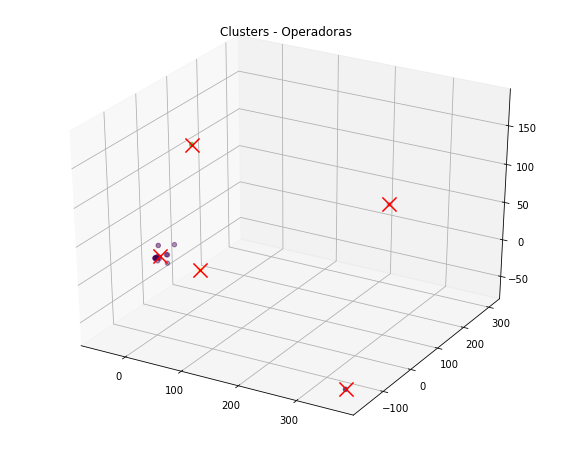

In [9]:
# Clusters 3D scatter plot.
fig, ax = plt.figure(figsize=(10, 8)), plt.axes(projection='3d')

x, y, z = preprocessed_X[:, 0], preprocessed_X[:, 1], preprocessed_X[:, 2]
ax.scatter3D(x, y, z, c=clusters);

x, y, z = centroids[:, 0], centroids[:, 1], centroids[:, 2]
ax.scatter3D(x, y, z, marker="x", s=200, c="red", depthshade=False);
plt.title('Clusters - Operadoras');